# Explore 2

This is a secondary exploration notebook used for additional analysis.

## The Required Imports

Everything we need to run the code blocks in this notebook are located in the top level directory. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn, sklearn, statsmodels, and prophet installed on your computer.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from scipy import stats

from wrangle import *
from acquire import AcquireSuperstore
from prepare import *

## Acquire and Prepare

Let's acquire and prepare the data.

In [2]:
dfs = wrangle()
superstore = dfs[0]
superstore.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2014-01-05 to 2017-12-31
Freq: W-SUN
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sales     209 non-null    float64
 1   quantity  209 non-null    float64
 2   discount  209 non-null    float64
 3   profit    209 non-null    float64
dtypes: float64(4)
memory usage: 8.2 KB


In [3]:
superstore_raw = clean_columns(AcquireSuperstore().get_data())
superstore_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1734 entries, 2014-01-04 to 2017-12-30
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ship_mode      1734 non-null   object 
 1   segment        1734 non-null   object 
 2   country        1734 non-null   object 
 3   city           1734 non-null   object 
 4   state          1734 non-null   object 
 5   sales          1734 non-null   float64
 6   quantity       1734 non-null   float64
 7   discount       1734 non-null   float64
 8   profit         1734 non-null   float64
 9   category       1734 non-null   object 
 10  sub_category   1734 non-null   object 
 11  customer_name  1734 non-null   object 
 12  product_name   1734 non-null   object 
 13  region_name    1734 non-null   object 
dtypes: float64(4), object(10)
memory usage: 203.2+ KB


## Discount vs. Profit

We are interested in seeing how the discount feature relates to profit. Let's find out.

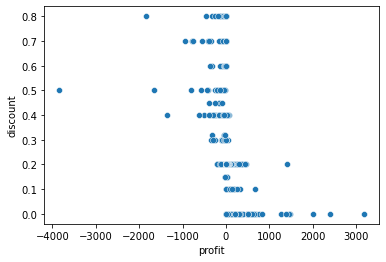

In [4]:
sns.scatterplot(data = superstore_raw, x = 'profit', y = 'discount');

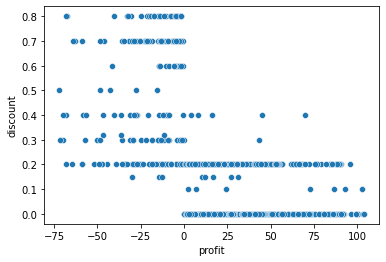

In [5]:
# What if we remove profit outliers
sns.scatterplot(
    data = remove_outliers(superstore_raw, 3.0, ['profit']),
    x = 'profit',
    y = 'discount'
);

/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_23057/1653770866.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])


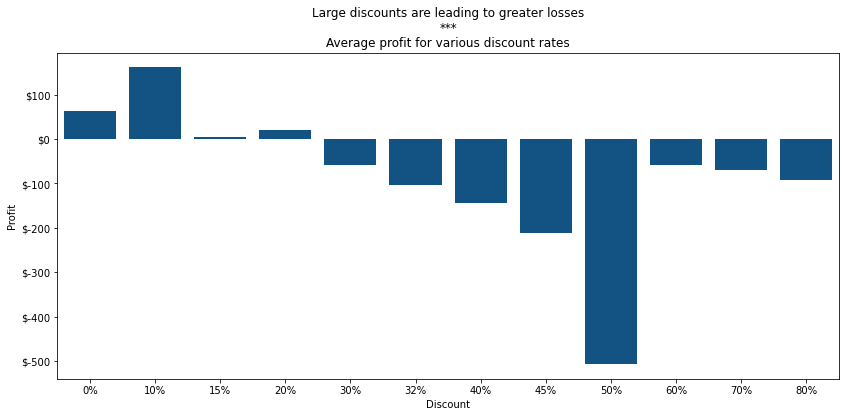

In [6]:
plt.figure(figsize = (14, 6))

ax = sns.barplot(
    data = superstore_raw,
    x = 'discount',
    y = 'profit',
    ci = None,
    palette = ['#005697']
)

ax.set_xticklabels(['0%', '10%', '15%', '20%', '30%', '32%', '40%', '45%', '50%', '60%', '70%', '80%'])
plt.xlabel('Discount')

ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])
plt.ylabel('Profit')

plt.title('Large discounts are leading to greater losses\n***\nAverage profit for various discount rates');

In [7]:
(superstore_raw.discount >= 0.3).sum()

246

In [8]:
246 / 1734

0.14186851211072665

## Quarterly Seasonal Plot

Let's create a seasonal plot resampled by quarter.

/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_23057/3768378556.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])


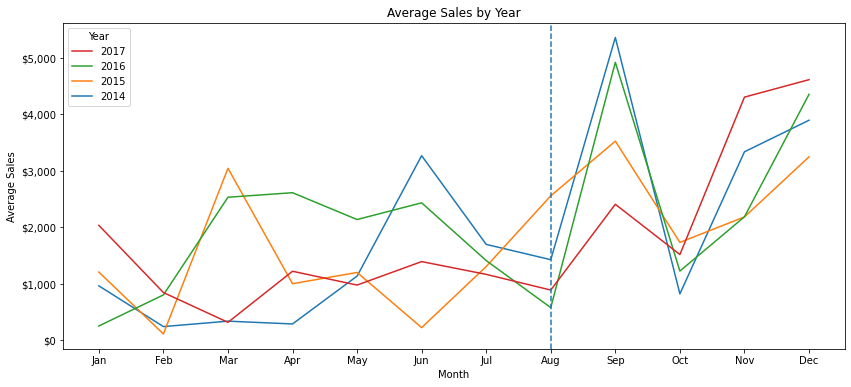

In [29]:
ax = superstore.groupby([superstore.index.year, superstore.index.month]).sales.mean().unstack(0).plot(figsize = (14, 6))
plt.title('Average Sales by Year')

plt.axvline(x = 8, linestyle = '--')

ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])
plt.ylabel('Average Sales')

plt.xticks(ticks = [x for x in range(1, 13)], labels = [month[ : 3] for month in superstore.index.month_name().unique()])
plt.xlabel('Month')

# Reorder labels in legend and add a title.
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    reversed(handles),
    reversed(labels),
    title = 'Year'
);

In [25]:
superstore.index.month_name().unique()

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object', name='order_date')

## Monthly Average Sales: Re-Formatting

Let's re-format the monthly average sales chart for presentation purposes.

/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_23057/4167010040.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])


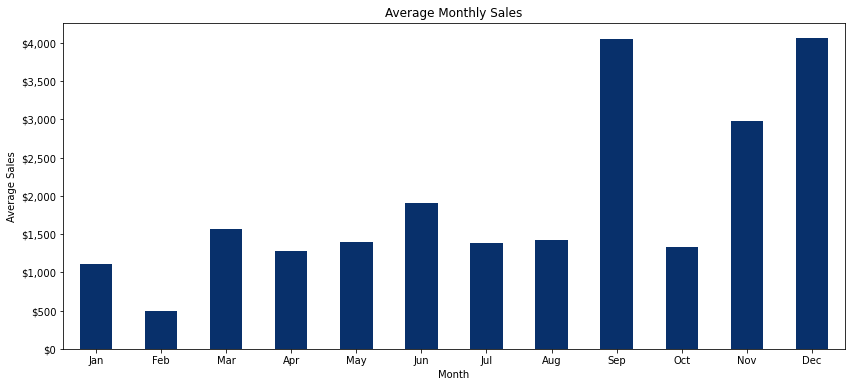

In [51]:
ax = superstore.groupby(superstore.index.month).sales.mean().plot(kind = 'bar', colormap = 'Blues_r', figsize = (14, 6))

ax.tick_params('x', rotation=0)
plt.xticks(ticks = [x for x in range(12)], labels = [month[ : 3] for month in superstore.index.month_name().unique()])

ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()])

ax.set(title='Average Monthly Sales', xlabel='Month', ylabel='Average Sales');

In [56]:
# Now for a stats test

# First test for equal variance.
# H0: The variance in sales volume for months January through June is equal to the variance in sales volume for 
# months July through December

alpha = 0.05
first_half = superstore.index.month < 6.5
second_half = superstore.index.month > 6.5

_, p = stats.levene(superstore[first_half].sales, superstore[second_half].sales)

if p < alpha:
    print('reject H0')
else:
    print('fail to reject H0')

reject H0


In [57]:
# H0: The average sales volume for months January through June is equal to the average sales volume for months July
# throught December.

_, p = stats.ttest_ind(superstore[first_half].sales, superstore[second_half].sales, equal_var = False)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

reject H0


There is a significant difference in sales volume between the first and second half of the year.

## Sales over time: re-formatting

Let's reformat the sales over time lineplot.

/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_23057/1406053865.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()]);


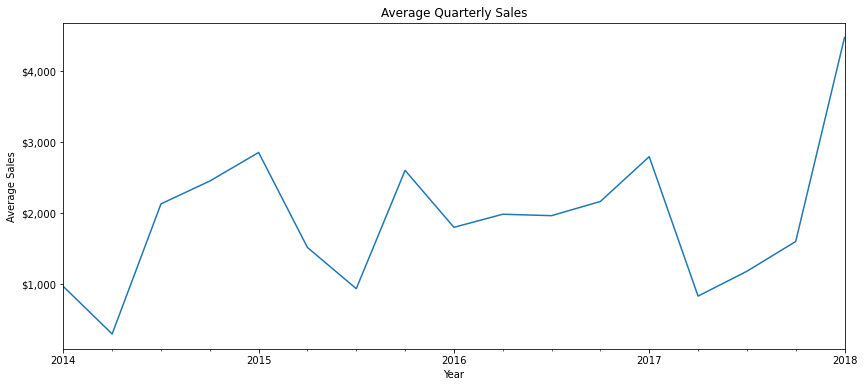

In [63]:
ax = superstore.sales.resample('3M').mean().plot(figsize = (14, 6))
plt.title('Average Quarterly Sales')

plt.xlabel('Year')

plt.ylabel('Average Sales')
ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()]);

/var/folders/95/v52kk6ys7s14hmmc3xm7b1xr0000gn/T/ipykernel_23057/3906734811.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()]);


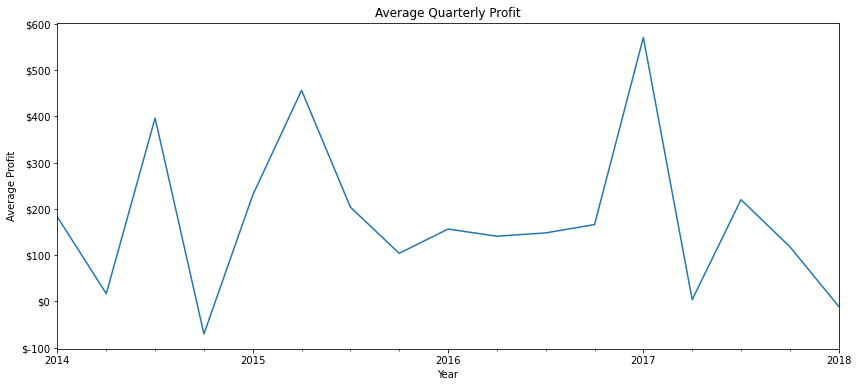

In [65]:
# Now profit

ax = superstore.profit.resample('3M').mean().plot(figsize = (14, 6))
plt.title('Average Quarterly Profit')

plt.xlabel('Year')

plt.ylabel('Average Profit')
ax.set_yticklabels([f'${tick:,.0f}' for tick in ax.get_yticks()]);

In [67]:
# Let's do a stats test on 2017 and 2014

# First test for equal variance.
# H0: The variance in sales volume for the year 2014 is equal to the variance in sales volume for 
# the year 2017

alpha = 0.05
year_2014 = superstore.index.year == 2014
year_2017 = superstore.index.year == 2017

_, p = stats.levene(superstore[year_2014].sales, superstore[year_2017].sales)

if p < alpha:
    print('reject H0')
else:
    print('fail to reject H0')

fail to reject H0


In [72]:
# H0: The average sales volume for 2017 is equal to the average sales volume for 2014.

_, p = stats.ttest_ind(superstore[year_2014].sales, superstore[year_2017].sales, equal_var = True)

if p < alpha:
    print('Reject H0')
else:
    print('Fail to reject H0')

Fail to reject H0
